In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
parent_dir_abs = os.path.abspath(os.pardir)
sys.path.insert(0, parent_dir_abs) 

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad, cumulative_trapezoid, trapezoid
from urllib.request import urlopen

import pyro
from pyro import poutine
from pyro import distributions as dist
from pyro_oed_src import posterior_loss
from pyro.contrib.util import lexpand, rexpand

import matplotlib.pyplot as plt
import seaborn as sns
import corner

from nflows.transforms import made as made_module
import neural_nets
import flows
import pyro_flows
from bed.grid import Grid, TopHat, CosineBump, Gaussian
from bed.design import ExperimentDesigner

from astropy.cosmology import Planck18
from astropy.cosmology import FLRW, w0waCDM, LambdaCDM, FlatLambdaCDM
from astropy import constants

import mlflow
import mlflow.pytorch
from tqdm import trange

import zuko

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

#set default dtype
torch.set_default_dtype(torch.float64)

Using device: cuda:0.


In [3]:
class bed_cosmology:

    def __init__(self, cosmo_params, priors, obs_labels, z_eff, true_n_vals, sigma_D_H, sigma_D_M=None, device=device):
        self.cosmo_params = set(cosmo_params)
        self.priors = priors
        self.obs_labels = obs_labels
        self.z_eff = z_eff
        self.sigma_D_H = sigma_D_H
        self.sigma_D_M = sigma_D_M
        self.true_n_vals = true_n_vals
        self.r_drag = 149.77
        self.H0 = Planck18.H0.value
        self.coeff = constants.c.to('km/s').value/(self.H0*self.r_drag)
        self.device = device
    
    def D_H_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om))

        elif self.cosmo_params == {'Om', 'w0'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+w0)))

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            return self.coeff / torch.sqrt(Om * (1+z)**3 + (1-Om) * (1+z)**(3*(1+(w0+wa*(z/(1+z))))))
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")

    def D_M_func(self, z, Om, w0=None, wa=None):
        if self.cosmo_params == {'Om'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)

        elif self.cosmo_params == {'Om', 'w0'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)) * (1 + z)**(3 * (1 + w0.unsqueeze(-1))))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)

        elif self.cosmo_params == {'Om', 'w0', 'wa'}:
            result = self.coeff * trapezoid(
                (1 / torch.sqrt(Om.unsqueeze(-1) * (1 + z)**3 + (1 - Om.unsqueeze(-1)) * (1 + z)**(3 * (1 + (w0.unsqueeze(-1) + wa.unsqueeze(-1) * (z / (1 + z))))))).cpu(), 
                z.cpu(), 
                axis=-1)
            return torch.tensor(result).to(self.device)
            
        else:
            raise ValueError(f"Unsupported cosmology model: {self.cosmo.name}")
    
    def pyro_model(self, num_tracers):
        with pyro.plate_stack("plate", num_tracers.shape[:-1]):
            parameters = {}
            for i, (k, v) in enumerate(self.priors.items()):
                if isinstance(v, dist.Distribution):
                    parameters[k] = pyro.sample(k, v).unsqueeze(-1)
                else:
                    parameters[k] = v

            z = self.z_eff.reshape((len(self.cosmo_params)-1)*[1] + [-1])
            means = self.D_H_func(z, **parameters)
            sigmas = self.sigma_D_H * torch.sqrt(self.true_n_vals/num_tracers)

            if self.sigma_D_M is not None:
                z_array = self.z_eff.unsqueeze(-1) * torch.linspace(0, 1, 100, device=self.device).view(1, -1)
                z = z_array.expand((len(self.cosmo_params)-1)*[1] + [-1, -1])
                D_M_mean = self.D_M_func(z, **parameters)
                D_M_sigmas = self.sigma_D_M * torch.sqrt(self.true_n_vals/num_tracers)
                means = torch.cat((means, D_M_mean), dim=-1)
                sigmas = torch.cat((sigmas, D_M_sigmas), dim=-1)

            #for i,o in enumerate(self.obs_labels):
            #    pyro.sample(o, dist.Normal(means[..., i].unsqueeze(-1), sigmas[..., i].unsqueeze(-1)).to_event(1))
            covariance_matrix = torch.diag_embed(sigmas ** 2)
            return pyro.sample("y", dist.MultivariateNormal(means, covariance_matrix))

    def unnorm_lfunc(self, params, features, designs):
        parameters = { }
        for key in params.names:
            parameters[key] = torch.tensor(getattr(params, key), device=self.device)
        likelihood = 1
        design_tracers = designs.names
        features_tracers = features.names
        for i in range(len(self.z_eff)):
            z = self.z_eff[i].reshape((len(self.cosmo_params)-1)*[1] + [-1])
            D_H_mean = self.D_H_func(z, **parameters)
            #plt.figure()
            #plt.hist(D_H_mean.cpu().numpy().flatten(), bins=100)
            #plt.title(f'D_H z={self.z_eff[i]}')
            #plt.yscale('log')
            #plt.show()
            D_H_diff = getattr(features, features_tracers[i]) - D_H_mean.cpu().numpy()
            D_H_sigma = (self.sigma_D_H.cpu().numpy()[i] * np.sqrt(self.true_n_vals.cpu().numpy()[i]/getattr(designs, design_tracers[i])))
            likelihood = np.exp(-0.5 * (D_H_diff / D_H_sigma) ** 2) * likelihood
            
            if self.sigma_D_M is not None:
                z_array = self.z_eff[i].unsqueeze(-1) * torch.linspace(0, 1, 100, device=self.device).view(1, -1)
                z = z_array.expand((len(self.cosmo_params)-1)*[1] + [-1, -1])
                D_M_mean = self.D_M_func(z, **parameters)
                plt.figure()
                plt.hist(D_M_mean.cpu().numpy().flatten(), bins=100)
                #plt.title(f'D_M z={self.z_eff[i]}')
                #plt.yscale('log')
                #plt.show()
                D_M_diff = getattr(features, features_tracers[i+len(self.z_eff)]) - D_M_mean.cpu().numpy()
                D_M_sigma = (self.sigma_D_M.cpu().numpy()[i] * np.sqrt(self.true_n_vals.cpu().numpy()[i]/getattr(designs, design_tracers[i])))
                likelihood = np.exp(-0.5 * (D_M_diff / D_M_sigma) ** 2) * likelihood

        return likelihood
            

In [4]:
include_D_M = True
tracers = ["LRG2", "Lya QSO"]
Om_range = torch.tensor([0.01, 1.0], device=device)
w0_range = torch.tensor([-3.0, 1.0], device=device)
wa_range = torch.tensor([-3.0, 2.0], device=device)
Om_sigma = 0.01
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
sigma_D_H = []
z_eff = []
true_n_vals = []
for t in tracers:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std)
    z_eff.append(z)
    true_n_vals.append(desi_data.loc[desi_data['tracer'] == t, "num"].values[0])

sigma_D_H = torch.tensor(sigma_D_H, device=device)
z_eff = torch.tensor(z_eff, device=device)
true_n_vals = torch.tensor(true_n_vals, device=device)

if include_D_M:
    sigma_D_M = []
    for t in tracers:
        D_M_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DM_over_rs'), "std"].values[0]
        sigma_D_M.append(D_M_std)
    sigma_D_M = torch.tensor(sigma_D_M, device=device)
    num_pts = 30
    grid_features = Grid(
        D_H_lrg=np.linspace(0, 130, num_pts), 
        D_H_lya=np.linspace(0, 50, num_pts), 
        D_M_lrg=np.linspace(0, 60, num_pts), 
        D_M_lya=np.linspace(0, 200, num_pts)
        )
else:
    sigma_D_M = None
    num_pts = 100
    grid_features = Grid(
        D_H_lrg=np.linspace(0.01, 300, num_pts), 
        D_H_lya=np.linspace(0.01, 160, num_pts)
        )

grid_designs_2 = Grid(N_lrg=np.arange(int(0.6*true_n_vals[0].cpu().numpy()), int(1.4*true_n_vals[0].cpu().numpy()), 15000),
    N_lya=np.arange(int(0.6*true_n_vals[1].cpu().numpy()), int(1.4*true_n_vals[1].cpu().numpy()), 15000), 
    constraint=lambda N_lrg, N_lya: abs((N_lrg + N_lya - torch.sum(true_n_vals).cpu().numpy())) < 10000)

num_pts = 20
params = ["Om", "w0", "wa"]
priors = {'Om': dist.Uniform(*Om_range), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}
grid_params = Grid(Om=np.linspace(*Om_range.cpu().numpy(), num_pts), w0=np.linspace(-3, 1, num_pts), wa=np.linspace(-3, 2, num_pts))
#grid_prior = Gaussian(grid_params.Om, Planck18.Om0, kwargs["Om_sigma"]) * TopHat(grid_params.w0) * TopHat(grid_params.wa)
#priors = {'Om': dist.Uniform(*Om_range), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}
grid_prior = TopHat(grid_params.Om) * TopHat(grid_params.w0) * TopHat(grid_params.wa)

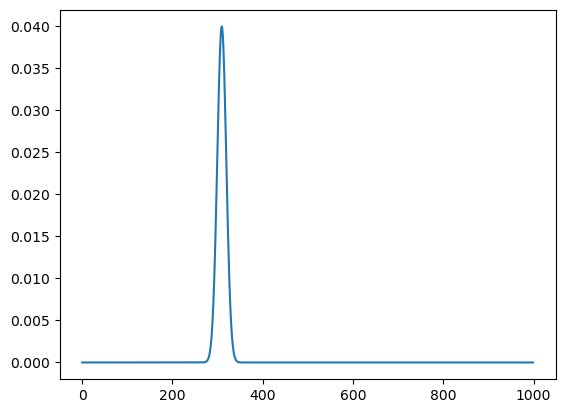

In [41]:
plt.plot(prior)
plt.show()

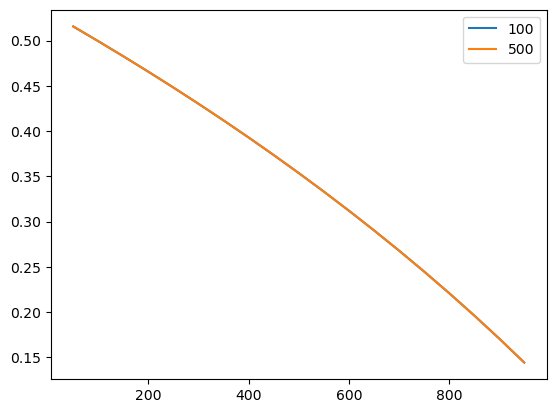

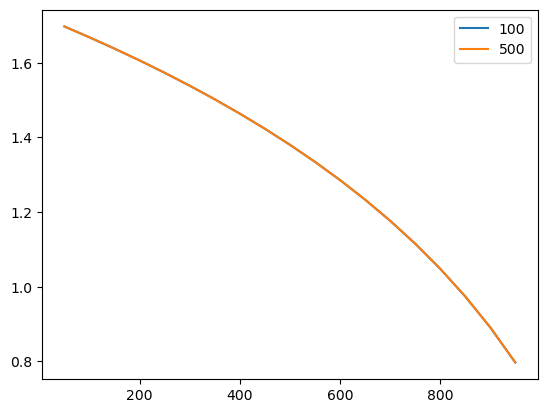

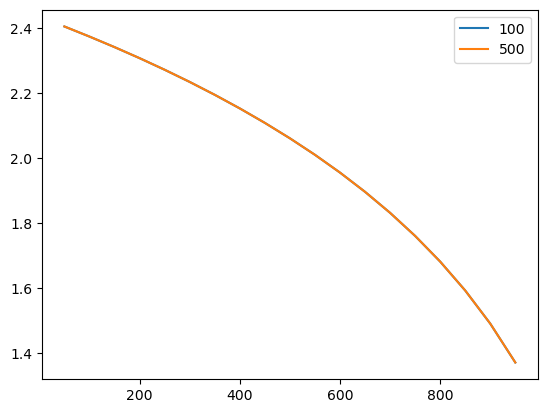

In [63]:
design_step = 50
priors = {'Om': dist.Normal(Planck18.Om0, Om_sigma)}
bed_cosmo = bed_cosmology(
    ["Om"],
    priors=priors,
    obs_labels=["y"],
    z_eff=z_eff,
    true_n_vals=torch.tensor([500,500]),
    sigma_D_H=sigma_D_H)
for Om_sigma in [0.01, 0.03, 0.05]:
    for d in [100, 500]:
        designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), constraint=lambda N_lrg, N_lya: N_lrg + N_lya == 1000)
        params = Grid(Om=np.linspace(0.0, 1.0, d))
        features = Grid(
        D_H_lrg=np.linspace(12, 30, 200), 
        D_H_lya=np.linspace(4, 30, 200)
        )
        prior = Gaussian(params.Om, Planck18.Om0, Om_sigma)
        designer = ExperimentDesigner(params, features, designs, bed_cosmo.unnorm_lfunc, mem=100000)
        params.normalize(prior);
        designer.calculateEIG(prior)
        plt.plot(designs.N_lrg, designer.EIG, label=f"{d}")
    plt.legend()
    plt.show()

In [5]:
desi_data

,tracer,num,rounded_num,z,value_at_z,std,quantity
0,LRG1,506905,507000,0.510,13.620031,0.251925,DM_over_rs
1,LRG1,506905,507000,0.510,20.983346,0.610712,DH_over_rs
2,LRG2,771875,772000,0.706,16.846453,0.319336,DM_over_rs
3,LRG2,771875,772000,0.706,20.078729,0.595356,DH_over_rs
4,LRG3+ELG1,1876164,1876000,0.930,21.708418,0.282077,DM_over_rs
5,LRG3+ELG1,1876164,1876000,0.930,17.876129,0.346317,DH_over_rs
6,ELG2,1415687,1416000,1.317,27.787208,0.690340,DM_over_rs
7,ELG2,1415687,1416000,1.317,13.823723,0.422221,DH_over_rs
8,Lya QSO,709565,710000,2.330,39.708383,0.943267,DM_over_rs
9,Lya QSO,709565,710000,2.330,8.522566,0.170839,DH_over_rs


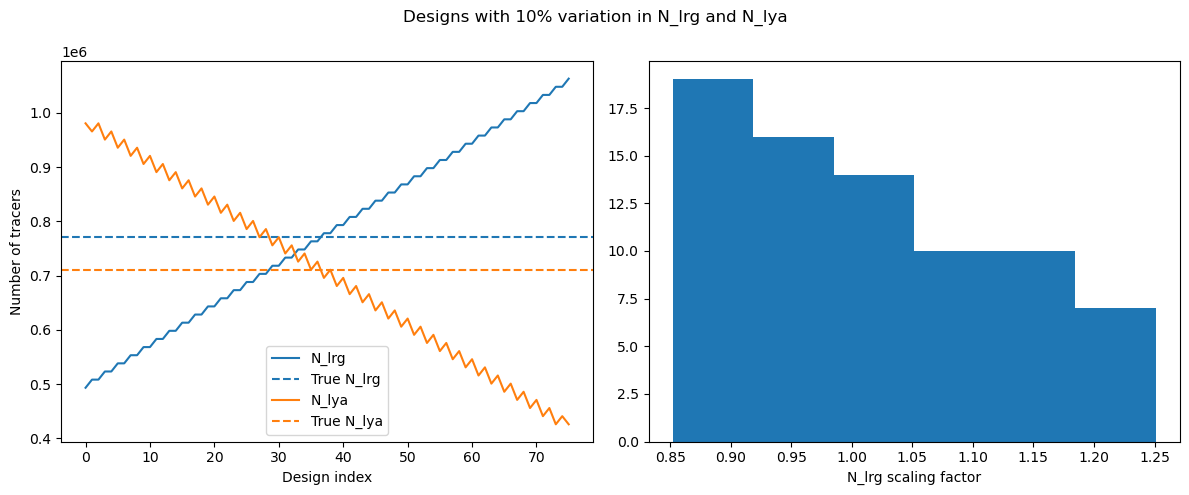

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(grid_designs_2.N_lrg, color="tab:blue", label='N_lrg')
axs[0].axhline(true_n_vals[0].cpu().numpy(), color='tab:blue', linestyle='--', zorder=0, label='True N_lrg')
axs[0].plot(grid_designs_2.N_lya, color="tab:orange", label='N_lya')
axs[0].axhline(true_n_vals[1].cpu().numpy(), color='tab:orange', linestyle='--', label='True N_lya', zorder=0)

axs[0].set_xlabel('Design index')
axs[0].set_ylabel('Number of tracers')
axs[0].legend()

axs[1].hist(np.sqrt(true_n_vals[0].cpu().numpy()/grid_designs_2.N_lrg), bins=6, color='tab:blue')
axs[1].set_xlabel('N_lrg scaling factor')
plt.suptitle('Designs with 10% variation in N_lrg and N_lya')
plt.tight_layout()
plt.show()

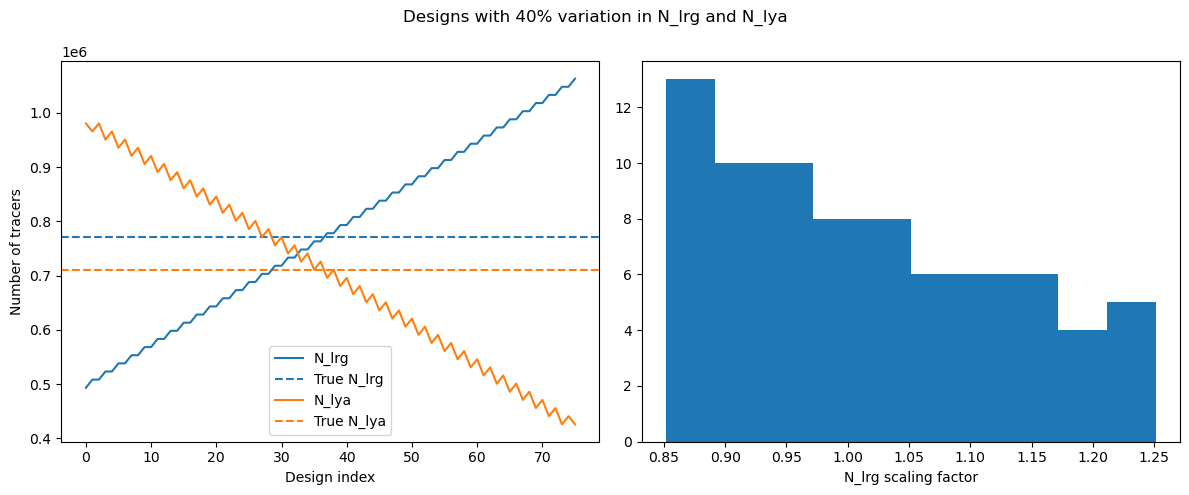

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(grid_designs_2.N_lrg, color="tab:blue", label='N_lrg')
axs[0].axhline(true_n_vals[0].cpu().numpy(), color='tab:blue', linestyle='--', zorder=0, label='True N_lrg')
axs[0].plot(grid_designs_2.N_lya, color="tab:orange", label='N_lya')
axs[0].axhline(true_n_vals[1].cpu().numpy(), color='tab:orange', linestyle='--', zorder=0, label='True N_lya')
axs[0].set_xlabel('Design index')
axs[0].set_ylabel('Number of tracers')
axs[0].legend()

axs[1].hist(np.sqrt(true_n_vals[0].cpu().numpy()/grid_designs_2.N_lrg), bins=10, color='tab:blue')
axs[1].set_xlabel('N_lrg scaling factor')
plt.suptitle('Designs with 40% variation in N_lrg and N_lya')
plt.tight_layout()
plt.show()

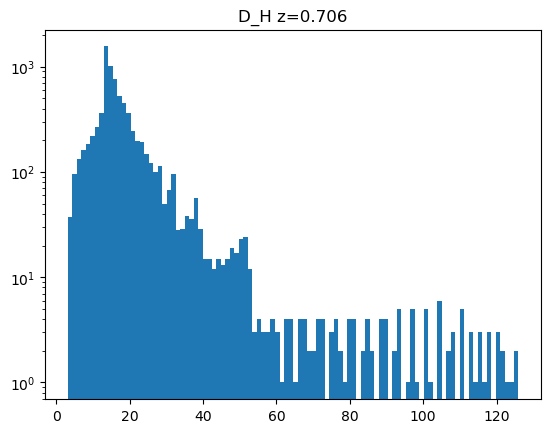

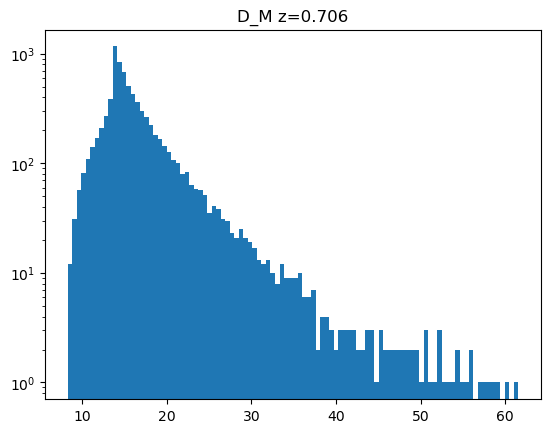

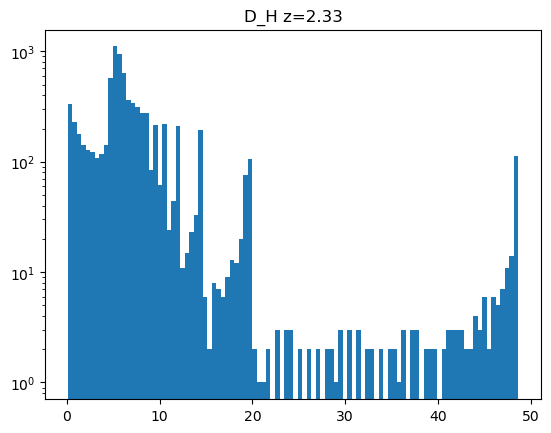

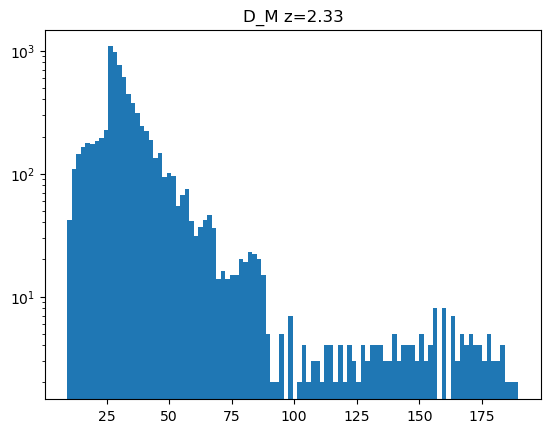

KeyboardInterrupt: 

In [85]:
designer = ExperimentDesigner(grid_params, grid_features, grid_designs, bed_cosmo.unnorm_lfunc, mem=100000)
designer.calculateEIG(grid_prior)
designer.describe()

In [4]:
desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

tracers = ["LRG2", "Lya QSO"]
#tracers = ["LRG2", "ELG2", "Lya QSO"]

include_D_M = False
cosmo_type = "Om"
design_step = 50

if len(tracers) == 2:
    grid_designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), constraint=lambda N_lrg, N_lya: N_lrg + N_lya == 1000)
elif len(tracers) == 3:
    grid_designs = Grid(N_lrg=np.arange(design_step, 1000 + design_step, design_step), N_lya=np.arange(design_step, 1000 + design_step, design_step), N_elg=np.arange(design_step, 1000 + design_step, design_step), constraint = lambda N_lrg, N_lya, N_elg: N_lrg + N_lya + N_elg == 1000)


if cosmo_type == "Om":
    params = Grid(Om=np.linspace(0.2, 0.4, 51))
elif cosmo_type == "w":
    num_pts = 25
    params = Grid(Om=np.linspace(0.2, 0.4, num_pts), w0=np.linspace(-3, 1, num_pts))
elif cosmo_type == "w0wa":
    num_pts = 25
    params = Grid(Om=np.linspace(0.2, 0.4, num_pts), w0=np.linspace(-3, 1, num_pts), wa=np.linspace(-3, 2, num_pts))

sigmas = []
z_eff = []
true_n_vals = []
for t in tracers:
    DH_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    sigmas.append(DH_std)
    redshift = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "z"].values[0]
    z_eff.append(redshift)

    if len(tracers) == 2:
        num_pts = 200
        features = Grid(D_H_lrg=np.linspace(14, 26, num_pts), D_H_lya=np.linspace(6, 12, num_pts))
    elif len(tracers) == 3:
        num_pts = 31
        features = Grid(D_H_lrg=np.linspace(5, 30, num_pts), D_H_lya=np.linspace(1, 11, num_pts), D_H_elg=np.linspace(0, 20, num_pts))

In [34]:
tracers = ["LRG2", "Lya QSO"]
design_step = 50
design_tot = 1000
cosmo_type = "w"
design_grids = []
for t in tracers:
    design_grids.append(torch.arange(design_step, 
        design_tot + design_step, 
        design_step))
output = torch.meshgrid(design_grids, indexing='ij')
design_combos = torch.stack(output,axis=len(tracers)).reshape(-1,len(tracers)).to(device)

# eliminate design_combos that don't sum to 1000
designs = design_combos[design_combos.sum(axis=1) == design_tot]

Om_range = torch.tensor([0.0, 1.0], device=device)
w0_range = torch.tensor([-3.0, 1.0], device=device)
wa_range = torch.tensor([-3.0, 2.0], device=device)

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')
sigma_D_H = []
z_eff = []
n_vals = []
for t in tracers:
    D_H_std = desi_data.loc[(desi_data['tracer'] == t) & (desi_data['quantity'] == 'DH_over_rs'), "std"].values[0]
    z = desi_data.loc[desi_data['tracer'] == t, "z"].values[0]
    sigma_D_H.append(D_H_std)
    z_eff.append(z)
    n_vals.append(500)
sigma_D_H = torch.tensor(sigma_D_H, device=device)
z_eff = torch.tensor(z_eff, device=device)
true_n_vals = torch.tensor(n_vals, device=device)

observation_labels = []
for t in tracers:
    observation_labels.append("D_H_"+t)

if cosmo_type == 'Om':
    ranges = [tuple(Om_range.cpu().detach().numpy())]
    priors = {'Om': dist.Uniform(*Om_range)}
    params = Grid(Om=np.linspace(*Om_range.cpu().detach().numpy(), 120))
elif cosmo_type == 'w':
    ranges = [tuple(Om_range.cpu().detach().numpy()), tuple(w0_range.cpu().detach().numpy())]
    priors = {'Om': dist.Uniform(*Om_range), 'w0': dist.Uniform(*w0_range)}
    params = Grid(Om=np.linspace(*Om_range.cpu().detach().numpy(), 60), 
        w0=np.linspace(*w0_range.cpu().detach().numpy(), 60))
elif cosmo_type == 'w0wa':
    ranges = [tuple(Om_range.cpu().detach().numpy()), tuple(w0_range.cpu().detach().numpy()), tuple(wa_range.cpu().detach().numpy())]
    priors = {'Om': dist.Uniform(*Om_range), 'w0': dist.Uniform(*w0_range), 'wa': dist.Uniform(*wa_range)}
    params = Grid(Om=np.linspace(*Om_range.cpu().detach().numpy(), 30), 
        w0=np.linspace(*w0_range.cpu().detach().numpy(), 30), 
        wa=np.linspace(*wa_range.cpu().detach().numpy(), 30))

observation_labels = []
for t in tracers:
    observation_labels.append("D_H_"+t)

target_labels = list(priors.keys())

In [35]:
prior = np.ones(params.shape)
params.normalize(prior);

In [22]:
parameters

{'Om': tensor([0.3627], device='cuda:0'),
 'w0': tensor([-1.7559], device='cuda:0')}

In [26]:
num_tracers = lexpand(designs, 100)

In [37]:
with pyro.plate_stack("plate", num_tracers.shape[:-1]):
    parameters = {}
    for i, (k, v) in enumerate(priors.items()):
        if isinstance(v, dist.Distribution):
            #parameters[k] = pyro.sample(k, v, obs=(torch.tensor(0.3)*torch.ones(num_tracers.shape[:-1])).to(device)).unsqueeze(-1)
            parameters[k] = pyro.sample(k, v).unsqueeze(-1)
        else:
            parameters[k] = v

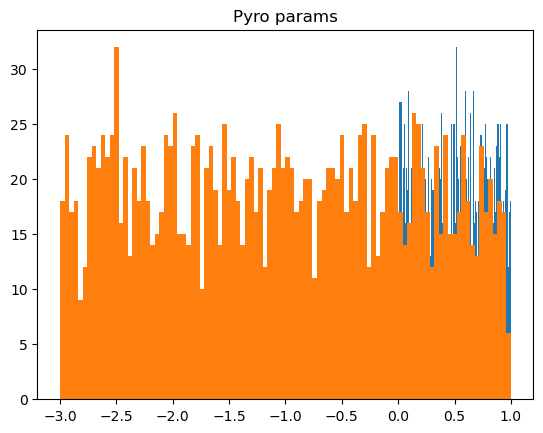

In [38]:
plt.hist(parameters['Om'].cpu().flatten(), bins=100)
plt.hist(parameters['w0'].cpu().flatten(), bins=100)
plt.title('Pyro params')
plt.show()

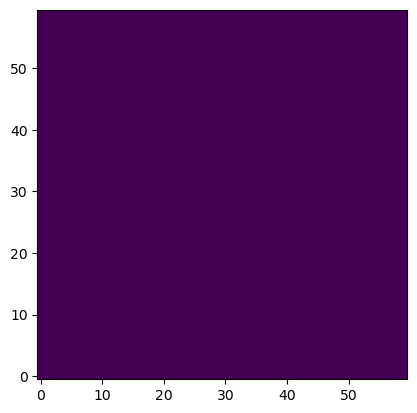

In [36]:
plt.imshow(prior, origin='lower')
plt.show()

In [7]:
np.linspace(*Om_range.cpu().detach().numpy())

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [ ]:
bed_cosmo = bed_cosmology(
    params,
    priors=priors,
    obs_labels=observation_labels,
    z_eff=z_eff,
    true_n_vals=true_n_vals,
    sigma_D_H=sigma_D_H)
    
plt.imshow(np.sum(bed_cosmo.likelihood(features, grid_designs, params), axis=(2,3,4)), origin='lower', extent=(features.D_H_lya.min(), features.D_H_lya.max(), features.D_H_lrg.min(), features.D_H_lrg.max()), aspect='auto')
plt.xlabel('D_H_lya')
plt.ylabel('D_H_lrg')
plt.colorbar()
plt.show()

In [8]:
posterior_flow = zuko.flows.MAF(
            features=1, 
            context=4, 
            transforms=10,
            univariate=zuko.transforms.MonotonicRQSTransform,
            shapes = ([24], [24], [23]),
            hidden_features=(100, 200, 200)).to(device)

lr = 1e-4
optimizer = torch.optim.Adam(posterior_flow.parameters(), lr=5e-3)

In [9]:
desi_data

,tracer,num,z,value_at_z,std,quantity
0,LRG1,506905,0.510,13.620031,0.251925,DM_over_rs
1,LRG1,506905,0.510,20.983346,0.610712,DH_over_rs
2,LRG2,771875,0.706,16.846453,0.319336,DM_over_rs
3,LRG2,771875,0.706,20.078729,0.595356,DH_over_rs
4,LRG3+ELG1,1876164,0.930,21.708418,0.282077,DM_over_rs
5,LRG3+ELG1,1876164,0.930,17.876129,0.346317,DH_over_rs
6,ELG2,1415687,1.317,27.787208,0.690340,DM_over_rs
7,ELG2,1415687,1.317,13.823723,0.422221,DH_over_rs
8,Lya QSO,709565,2.330,39.708383,0.943267,DM_over_rs
9,Lya QSO,709565,2.330,8.522566,0.170839,DH_over_rs


In [13]:
designs.shape

torch.Size([19, 2])

In [ ]:
bed_cosmo = bed_cosmology(
    params,
    priors=priors,
    obs_labels=observation_labels,
    z_eff=z_eff,
    true_n_vals=true_n_vals,
    sigma_D_H=sigma_D_H)
    
verbose_shapes = True
for step in range(1000):
        optimizer.zero_grad() #  clear gradients from previous step
        agg_loss, loss = posterior_loss(design=designs,
                                        model=bed_cosmo.pyro_model,
                                        guide=posterior_flow,
                                        num_particles=51,
                                        observation_labels=["D_H"],
                                        target_labels=target_labels,
                                        evaluation=False,
                                        nflow=True,
                                        condition_design=True,
                                        verbose_shapes=verbose_shapes)
        agg_loss.backward()
        optimizer.step()

        if step == 0:
            verbose_shapes = False
        with torch.no_grad():
            agg_loss, eigs = posterior_loss(design=designs,
                                            model=bed_cosmo.pyro_model,
                                            guide=posterior_flow,
                                            num_particles=100,
                                            observation_labels=["D_H"],
                                            target_labels=target_labels,
                                            evaluation=True,
                                            nflow=True,
                                            condition_design=True)
                                            

Om torch.Size([51, 19, 1])
w0 torch.Size([51, 19, 1])
wa torch.Size([51, 19, 1])
z_eff tensor([0.7060, 2.3300], device='cuda:0')
sigma_D_H tensor([0.5954, 0.1708], device='cuda:0')
true_n_vals tensor([500, 500], device='cuda:0')
pyro torch.Size([51, 19, 2]) torch.Size([51, 19, 2])
